# **Libraries&Importing Processes**

In [ ]:
!pip install missingno
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.0 MB/s 
     |████████████████████████████████| 209 kB 48.1 MB/s 
     |████████████████████████████████| 81 kB 9.2 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 49 kB 6.6 MB/s 
     |████████████████████████████████| 112 kB 56.5 MB/s 
     |████████████████████████████████| 147 kB 45.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1d43d9692b4e5f08f403c189ed6aed7e09df55eaa202608870985e4fae07ee04
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fc

In [ ]:
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns 
import datetime as dt
import missingno as msno
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from sklearn import preprocessing
import statsmodels.stats.api as sms
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV,RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import LocalOutlierFactor
from google.colab import drive
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
train = pd.read_csv('/content/training_dataset.csv')
test = pd.read_csv('/content/test_dataset.csv')

train.drop(['region__peak_returns_dollar_amt_per_hour_v2','region__peak_sales_dollar_amt_per_hour_v2'],axis=1,inplace=True)
test.drop(['region__peak_returns_dollar_amt_per_hour_v2','region__peak_sales_dollar_amt_per_hour_v2'],axis=1,inplace=True)

# **EDA**

In [ ]:
# General Exploration for Dataset
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

# Categorical & Numerical Variables:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and "ID" not in col]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


# Categorical Variables:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

#  Numerical Variables:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

In [ ]:
check_df(train)

##################### Shape #####################
(18512, 61)
##################### Types #####################
Unnamed: 0                                       int64
observation_id                                  object
observation_timestamp                           object
hour_of_day                                      int64
register__sales_dollar_amt_this_hour           float64
register__payment_types_accepted                object
register__peak_sales_dollar_amt_per_hour       float64
register__sales_dollar_amt_last_hour           float64
register__sales_quantity_last_hour             float64
register__sales_quantity_rescanned_frac        float64
register__sales_payments_declined_frac         float64
register__peak_returns_dollar_amt_per_hour     float64
register__returns_dollar_amt_last_hour         float64
register__returns_quantity_last_hour           float64
register__returns_quantity_rescanned_frac      float64
cashier__title_level                           float64
cashier_

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(train)
print(cat_cols)
print(num_cols)

Observations: 18512
Variables: 61
cat_cols: 7
num_cols: 52
cat_but_car: 2
num_but_cat: 5
['register__payment_types_accepted', 'store__type_code', 'cashier__title_level', 'cashier__n_years_experience', 'store__n_employees_total', 'store__n_baggers', 'store__is_sufficiently_staffed']
['Unnamed: 0', 'hour_of_day', 'register__sales_dollar_amt_this_hour', 'register__peak_sales_dollar_amt_per_hour', 'register__sales_dollar_amt_last_hour', 'register__sales_quantity_last_hour', 'register__sales_quantity_rescanned_frac', 'register__sales_payments_declined_frac', 'register__peak_returns_dollar_amt_per_hour', 'register__returns_dollar_amt_last_hour', 'register__returns_quantity_last_hour', 'register__returns_quantity_rescanned_frac', 'cashier__hours_into_shift', 'cashier__item_scan_rate_per_min', 'cashier__item_manual_entry_rate_per_min', 'store__miles_to_nearest_location', 'store__target_sales_quantity_per_hour', 'store__mean_customer_to_staff_ratio', 'store__mean_service_time_per_customer', 'st

                   register__payment_types_accepted     Ratio
Cash+Credit                                   16310 88.105013
Cash+Credit+Check                              2133 11.522256
Credit                                           69  0.372731
##########################################


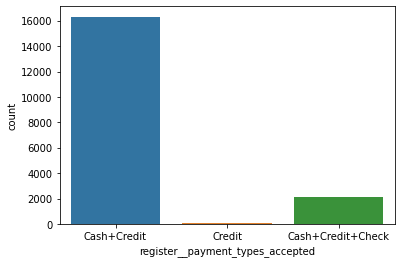

   store__type_code     Ratio
A             11691 63.153630
C              5637 30.450519
B               861  4.651037
D               316  1.707001
F                 5  0.027010
E                 2  0.010804
##########################################


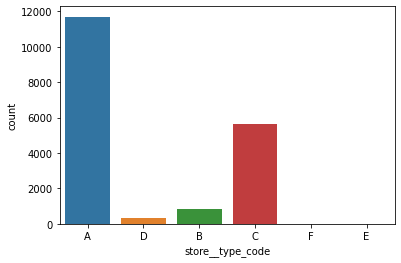

           cashier__title_level     Ratio
-0.352000                 14373 77.641530
1.899600                   3509 18.955272
-2.603600                   630  3.403198
##########################################


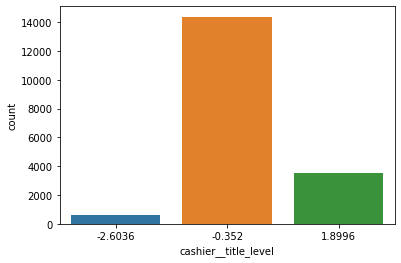

           cashier__n_years_experience     Ratio
-0.745400                         9957 53.786733
1.046300                          7900 42.675022
-2.537100                          573  3.095290
2.838000                            82  0.442956
##########################################


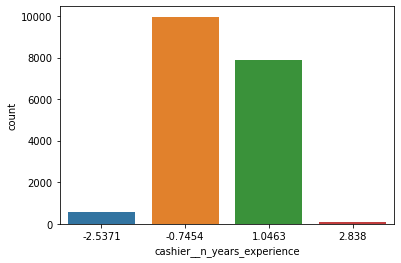

           store__n_employees_total     Ratio
-0.296000                      6780 36.624892
0.954900                       6699 36.187338
0.058000                       1988 10.738980
-1.358100                       978  5.283060
-2.904100                       873  4.715860
-1.499700                       865  4.672645
1.379700                        320  1.728608
-0.508400                         9  0.048617
##########################################


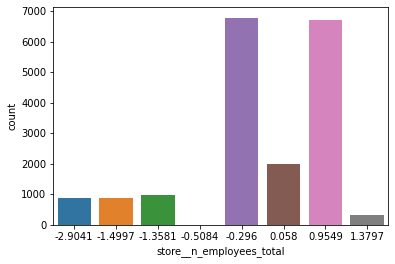

           store__n_baggers     Ratio
-0.637100              8934 48.260588
0.165700               7792 42.091616
1.771200               1352  7.303371
4.982300                434  2.344425
##########################################


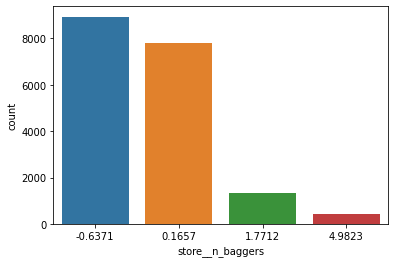

           store__is_sufficiently_staffed     Ratio
-0.390900                           16335 88.240061
2.558200                             2177 11.759939
##########################################


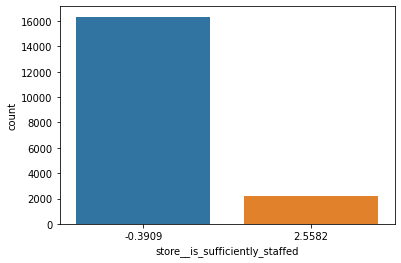

count   18512.000000
mean     9255.500000
std      5344.098427
min         0.000000
5%        925.550000
10%      1851.100000
20%      3702.200000
30%      5553.300000
40%      7404.400000
50%      9255.500000
60%     11106.600000
70%     12957.700000
80%     14808.800000
90%     16659.900000
95%     17585.450000
99%     18325.890000
max     18511.000000
Name: Unnamed: 0, dtype: float64


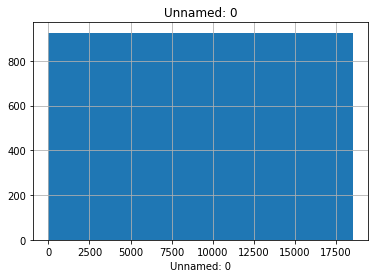

count   18512.000000
mean       12.316659
std         7.690665
min         0.000000
5%          0.000000
10%         1.000000
20%         4.000000
30%         6.000000
40%        10.000000
50%        14.000000
60%        17.000000
70%        19.000000
80%        20.000000
90%        22.000000
95%        23.000000
99%        23.000000
max        23.000000
Name: hour_of_day, dtype: float64


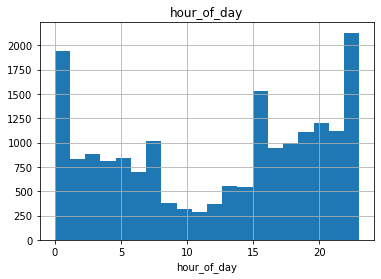

count   18512.000000
mean     1169.814248
std       818.455239
min        15.710000
5%        234.943000
10%       309.092000
20%       363.822000
30%       372.620000
40%       946.178000
50%      1165.795000
60%      1368.390000
70%      1438.764000
80%      1696.596000
90%      2180.891000
95%      2494.096500
99%      3939.923100
max      4978.650000
Name: register__sales_dollar_amt_this_hour, dtype: float64


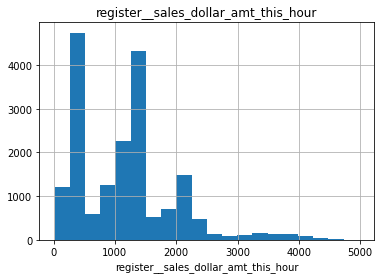

count   18512.000000
mean        0.002944
std         1.007499
min        -0.985800
5%         -0.738300
10%        -0.675700
20%        -0.624100
30%        -0.624100
40%        -0.559400
50%        -0.335700
60%         0.051900
70%         0.308400
80%         0.474200
90%         0.648300
95%         1.007600
99%         5.623500
max         6.021600
Name: register__peak_sales_dollar_amt_per_hour, dtype: float64


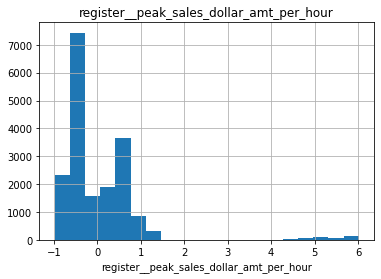

count   18512.000000
mean        0.000513
std         1.119465
min        -0.127000
5%         -0.127000
10%        -0.127000
20%        -0.126900
30%        -0.126500
40%        -0.125900
50%        -0.125000
60%        -0.122100
70%        -0.114530
80%        -0.026020
90%         0.317720
95%         0.692070
99%         1.281712
max       146.352200
Name: register__sales_dollar_amt_last_hour, dtype: float64


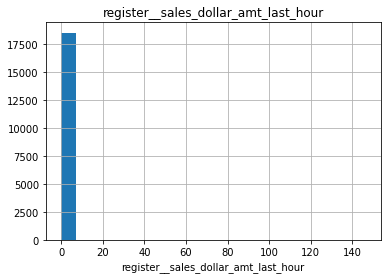

count   18512.000000
mean        0.001174
std         1.113356
min        -0.199400
5%         -0.199000
10%        -0.198800
20%        -0.198200
30%        -0.196200
40%        -0.177300
50%        -0.168600
60%        -0.134700
70%        -0.066530
80%         0.044580
90%         0.416630
95%         0.725545
99%         1.953151
max       141.513200
Name: register__sales_quantity_last_hour, dtype: float64


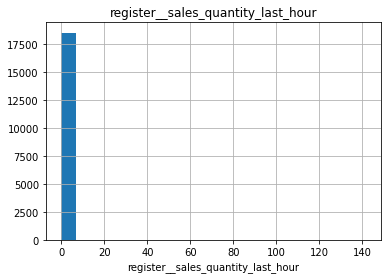

count   18512.000000
mean       -0.014366
std         0.988478
min        -0.829900
5%         -0.829900
10%        -0.822800
20%        -0.788300
30%        -0.736870
40%        -0.595060
50%        -0.368350
60%        -0.162400
70%         0.136370
80%         0.679960
90%         1.504390
95%         2.035480
99%         3.203587
max         7.850300
Name: register__sales_quantity_rescanned_frac, dtype: float64


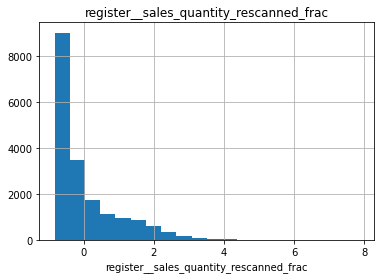

count   18512.000000
mean        0.001537
std         1.037091
min        -0.124700
5%         -0.124700
10%        -0.124700
20%        -0.124700
30%        -0.124700
40%        -0.124700
50%        -0.124700
60%        -0.124700
70%        -0.124700
80%        -0.121100
90%        -0.040100
95%         0.290600
99%         2.699953
max        55.379800
Name: register__sales_payments_declined_frac, dtype: float64


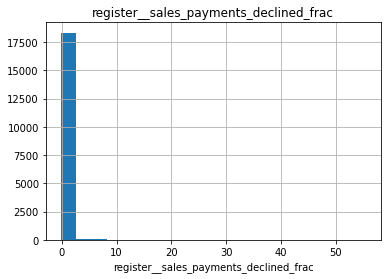

count   18512.000000
mean        0.006712
std         1.010382
min        -0.585200
5%         -0.572100
10%        -0.525100
20%        -0.525100
30%        -0.525100
40%        -0.525100
50%        -0.525100
60%        -0.135100
70%        -0.135100
80%         0.457100
90%         0.979500
95%         1.294300
99%         5.686500
max         5.686500
Name: register__peak_returns_dollar_amt_per_hour, dtype: float64


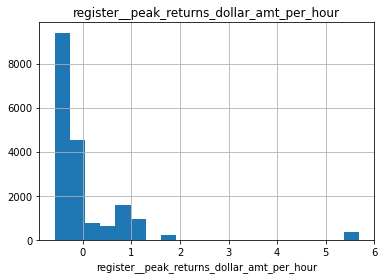

count   18512.000000
mean        0.003119
std         1.107004
min        -0.258200
5%         -0.258200
10%        -0.258100
20%        -0.258100
30%        -0.257800
40%        -0.252800
50%        -0.247500
60%        -0.217400
70%        -0.072430
80%         0.195280
90%         0.779400
95%         0.847400
99%         1.755367
max       136.491200
Name: register__returns_dollar_amt_last_hour, dtype: float64


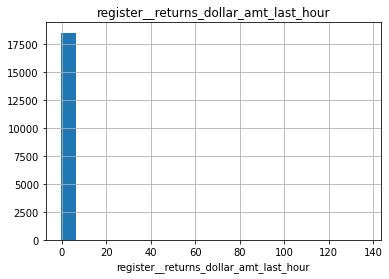

count   18512.000000
mean        0.002602
std         1.110886
min        -0.262100
5%         -0.261600
10%        -0.261100
20%        -0.259600
30%        -0.256700
40%        -0.236200
50%        -0.204700
60%        -0.173700
70%        -0.045300
80%         0.207700
90%         0.665180
95%         0.827990
99%         1.573078
max       139.600000
Name: register__returns_quantity_last_hour, dtype: float64


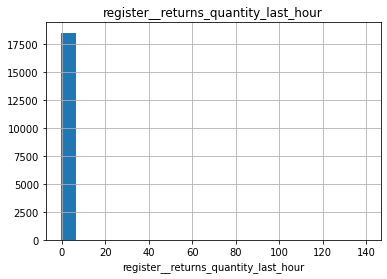

count   18512.000000
mean       -0.024150
std         0.960737
min        -0.533700
5%         -0.533700
10%        -0.533700
20%        -0.529300
30%        -0.518300
40%        -0.481360
50%        -0.398200
60%        -0.302600
70%        -0.176100
80%         0.107600
90%         1.017590
95%         2.317080
99%         4.114368
max         9.693300
Name: register__returns_quantity_rescanned_frac, dtype: float64


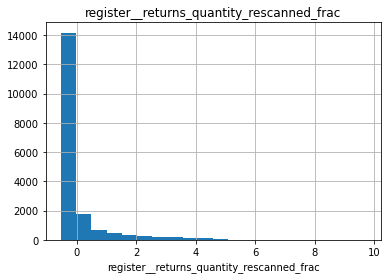

count   18512.000000
mean        0.005945
std         0.992792
min        -0.718300
5%         -0.707300
10%        -0.691190
20%        -0.645900
30%        -0.577300
40%        -0.481200
50%        -0.347400
60%        -0.198440
70%         0.009870
80%         0.319760
90%         1.263020
95%         1.943000
99%         4.468012
max         4.700100
Name: cashier__hours_into_shift, dtype: float64


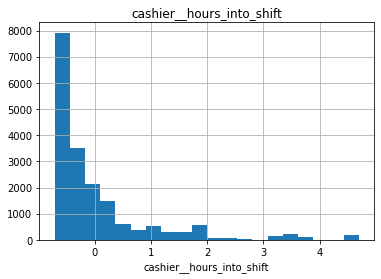

count   18512.000000
mean       -0.001230
std         1.007069
min        -3.618100
5%         -1.763400
10%        -1.557300
20%        -1.145200
30%        -0.320900
40%        -0.114800
50%         0.091300
60%         0.400400
70%         0.812500
80%         0.915600
90%         1.121700
95%         1.121700
99%         1.946000
max         3.491600
Name: cashier__item_scan_rate_per_min, dtype: float64


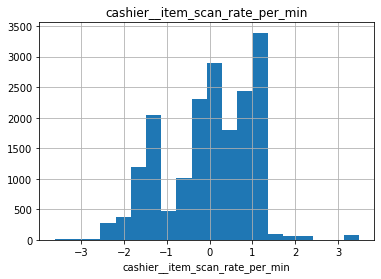

count   18512.000000
mean       -0.001449
std         1.008924
min        -6.931000
5%         -2.136700
10%        -1.407100
20%        -0.990200
30%        -0.260700
40%         0.156200
50%         0.260500
60%         0.468900
70%         0.677300
80%         0.885800
90%         0.990000
95%         0.990000
99%         1.719600
max         2.866000
Name: cashier__item_manual_entry_rate_per_min, dtype: float64


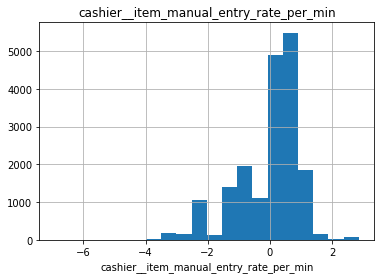

count   18512.000000
mean        0.030023
std         0.977420
min        -2.652400
5%         -2.134200
10%        -2.134200
20%         0.197300
30%         0.197300
40%         0.197300
50%         0.197300
60%         0.456400
70%         0.456400
80%         0.715500
90%         0.974500
95%         0.974500
99%         0.974500
max         1.492700
Name: store__miles_to_nearest_location, dtype: float64


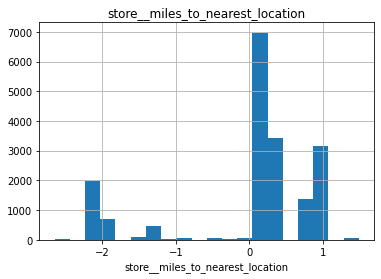

count   18512.000000
mean       -0.022675
std         0.917017
min        -7.104400
5%         -0.300100
10%        -0.242400
20%        -0.197900
30%        -0.169100
40%        -0.064700
50%         0.001900
60%         0.037500
70%         0.057400
80%         0.077400
90%         0.090800
95%         0.104100
99%         0.104100
max        15.447100
Name: store__target_sales_quantity_per_hour, dtype: float64


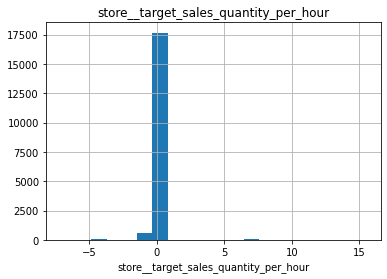

count   18512.000000
mean        0.000694
std         1.009366
min        -1.629600
5%         -0.923100
10%        -0.923100
20%        -0.923100
30%        -0.923100
40%        -0.569900
50%        -0.216600
60%         0.489900
70%         0.489900
80%         0.843200
90%         1.196400
95%         1.549700
99%         2.609500
max        22.391900
Name: store__mean_customer_to_staff_ratio, dtype: float64


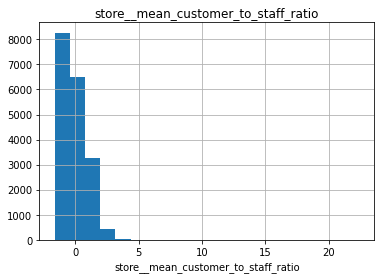

count   18512.000000
mean        0.016124
std         1.002453
min        -1.220600
5%         -1.107300
10%        -1.058990
20%        -0.764100
30%        -0.303170
40%        -0.155460
50%        -0.042050
60%         0.156480
70%         0.287600
80%         0.436460
90%         0.664300
95%         1.118445
99%         4.020235
max        24.922100
Name: store__mean_service_time_per_customer, dtype: float64


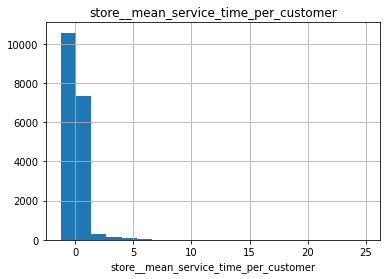

count   18512.000000
mean        0.002485
std         1.004449
min        -0.938100
5%         -0.938100
10%        -0.938100
20%        -0.365700
30%        -0.365700
40%        -0.365700
50%        -0.365700
60%        -0.365700
70%         0.206800
80%         0.206800
90%         0.206800
95%         1.924300
99%         4.214200
max         4.786700
Name: store__n_managers, dtype: float64


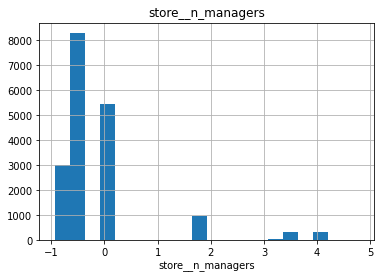

count   18512.000000
mean        0.014078
std         1.006427
min        -0.753600
5%         -0.753600
10%        -0.753600
20%        -0.753600
30%        -0.579600
40%        -0.579600
50%        -0.405700
60%        -0.057800
70%         0.116100
80%         0.464000
90%         1.159700
95%         2.725000
99%         3.594700
max         3.768600
Name: store__n_open_registers, dtype: float64


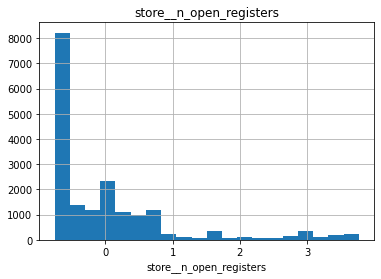

count   18512.000000
mean        0.002835
std         1.003090
min        -0.646300
5%         -0.645700
10%        -0.644400
20%        -0.641500
30%        -0.622500
40%        -0.571860
50%        -0.534700
60%        -0.441000
70%        -0.206860
80%         0.790000
90%         1.945390
95%         2.250490
99%         2.502234
max         8.148100
Name: store__occupancy_main_floor, dtype: float64


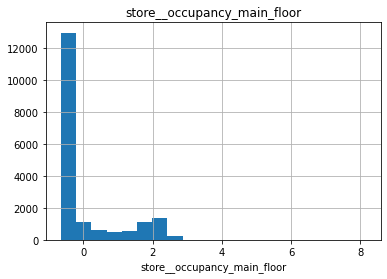

count   18512.000000
mean        0.005949
std         0.997506
min        -0.849200
5%         -0.797600
10%        -0.730700
20%        -0.657080
30%        -0.598900
40%        -0.480060
50%        -0.403650
60%        -0.231480
70%         0.036670
80%         0.542480
90%         1.399550
95%         2.282035
99%         3.186740
max        10.782800
Name: store__occupancy_grocery, dtype: float64


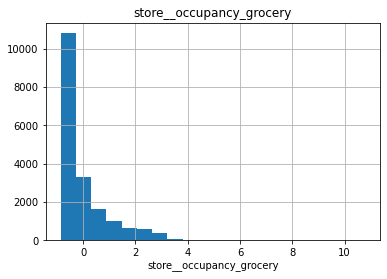

count   18512.000000
mean       -0.026494
std         0.967587
min        -0.438600
5%         -0.438600
10%        -0.438600
20%        -0.438600
30%        -0.438600
40%        -0.436200
50%        -0.346700
60%        -0.225640
70%        -0.066100
80%         0.143660
90%         0.500490
95%         1.302170
99%         4.077979
max        13.518900
Name: store__occupancy_checkout_areas, dtype: float64


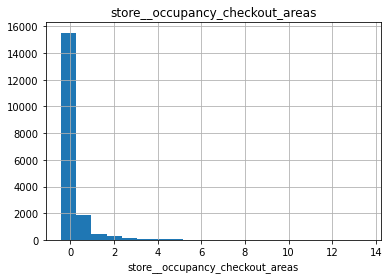

count   18512.000000
mean       -0.000883
std         0.995046
min        -0.884100
5%         -0.876000
10%        -0.866690
20%        -0.772600
30%        -0.599820
40%        -0.439000
50%        -0.286500
60%        -0.096100
70%         0.164170
80%         0.557200
90%         1.169760
95%         1.828675
99%         3.732626
max        13.203600
Name: store__occupancy_food_court, dtype: float64


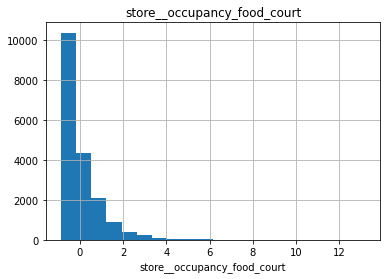

count   18512.000000
mean       -0.004780
std         0.994366
min        -0.181200
5%         -0.181200
10%        -0.181100
20%        -0.173200
30%        -0.158370
40%        -0.137500
50%        -0.113800
60%        -0.078440
70%        -0.033500
80%         0.041580
90%         0.177100
95%         0.306135
99%         0.725836
max        44.415900
Name: store__occupancy_backrooms, dtype: float64


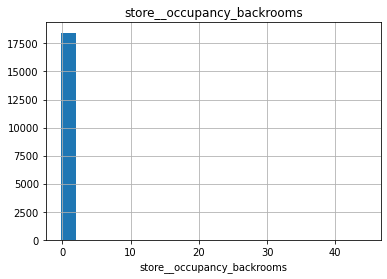

count   18512.000000
mean       -0.002356
std         1.002190
min        -1.006300
5%         -0.963345
10%        -0.904990
20%        -0.842900
30%        -0.714600
40%        -0.577760
50%        -0.372300
60%        -0.099240
70%         0.262270
80%         0.772960
90%         1.579840
95%         2.222445
99%         2.774856
max         5.224300
Name: store__occupancy_indoors, dtype: float64


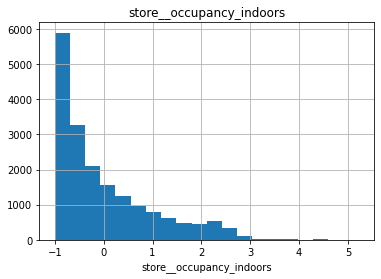

count   18512.000000
mean       -0.021494
std         0.981435
min        -0.708700
5%         -0.702700
10%        -0.686090
20%        -0.612000
30%        -0.519400
40%        -0.406900
50%        -0.257100
60%        -0.110300
70%         0.044510
80%         0.248300
90%         0.721370
95%         1.457390
99%         4.140904
max        15.654700
Name: store__occupancy_outdoors, dtype: float64


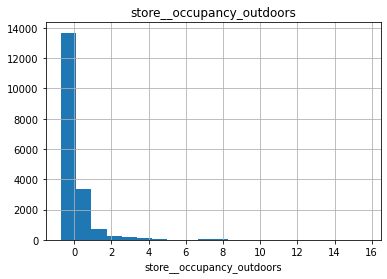

count   18512.000000
mean       -0.030302
std         0.986377
min        -2.279700
5%         -1.501700
10%        -1.210000
20%        -1.015500
30%        -0.723700
40%        -0.334800
50%         0.012800
60%         0.230700
70%         0.448500
80%         0.775200
90%         1.123800
95%         1.610000
99%         2.300200
max         5.013600
Name: store__outdoor_temperature, dtype: float64


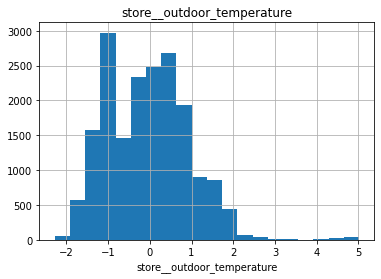

count   18512.000000
mean       -0.023004
std         0.996865
min        -1.224200
5%         -1.107000
10%        -1.087090
20%        -1.053200
30%        -1.039200
40%        -1.011020
50%         0.064300
60%         0.892420
70%         0.944270
80%         1.008380
90%         1.179080
95%         1.257100
99%         1.298778
max         3.090800
Name: store__parking_lot_utilization, dtype: float64


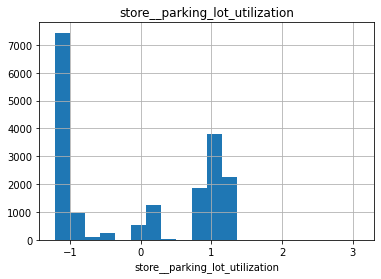

count   18512.000000
mean       -0.030949
std         0.984071
min        -4.926500
5%         -1.558900
10%        -1.429300
20%        -0.652200
30%        -0.263600
40%        -0.263600
50%        -0.134100
60%         0.254500
70%         0.384000
80%         0.772600
90%         0.902100
95%         1.161200
99%         2.586000
max         7.248900
Name: store__shelf_freespace_frac, dtype: float64


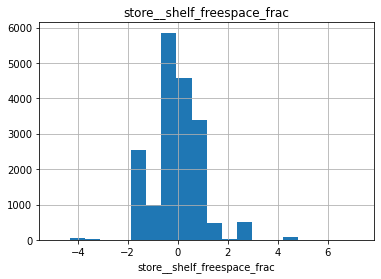

count   18512.000000
mean       -0.010074
std         0.996157
min        -1.180400
5%         -1.104400
10%        -1.034500
20%        -0.760860
30%        -0.429100
40%        -0.315900
50%        -0.215300
60%        -0.075740
70%         0.101770
80%         0.347740
90%         1.009070
95%         1.632290
99%         2.825689
max         6.721000
Name: store__hrs_since_last_delivery, dtype: float64


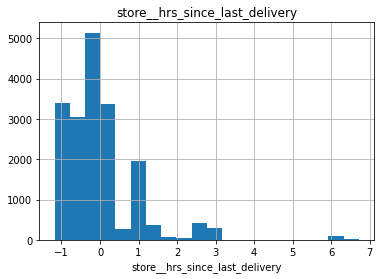

count   18512.000000
mean        0.002377
std         1.011207
min        -0.549300
5%         -0.549200
10%        -0.549100
20%        -0.548900
30%        -0.546100
40%        -0.534500
50%        -0.520000
60%        -0.461300
70%        -0.134030
80%         0.424300
90%         1.707080
95%         1.896745
99%         3.825091
max        14.652900
Name: store__sales_dollar_amt_last_hour, dtype: float64


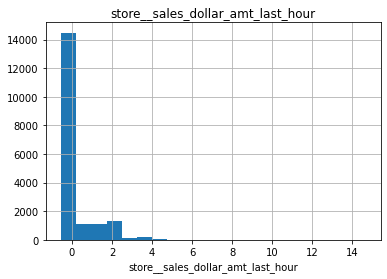

count   18512.000000
mean        0.002736
std         1.012666
min        -0.595900
5%         -0.595300
10%        -0.594600
20%        -0.593200
30%        -0.580800
40%        -0.536760
50%        -0.501950
60%        -0.382900
70%        -0.124130
80%         0.440460
90%         1.599170
95%         1.983425
99%         3.788726
max        12.342400
Name: store__sales_quantity_last_hour, dtype: float64


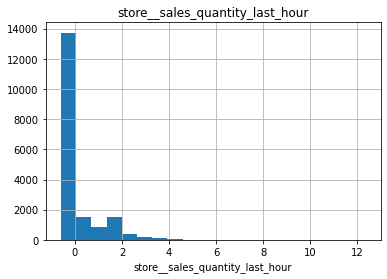

count   18512.000000
mean        0.000494
std         1.103591
min        -0.012400
5%         -0.012400
10%        -0.012400
20%        -0.012400
30%        -0.012400
40%        -0.012400
50%        -0.012400
60%        -0.012400
70%        -0.012400
80%        -0.012400
90%        -0.012400
95%        -0.012400
99%        -0.012400
max       147.513500
Name: store__sales_quantity_rescanned_frac, dtype: float64


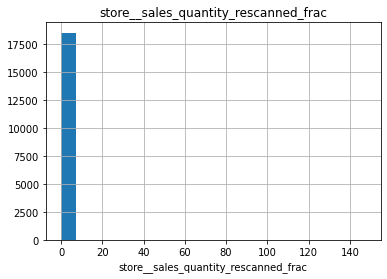

count   18512.000000
mean       -0.027451
std         0.975194
min        -0.411900
5%         -0.411900
10%        -0.411900
20%        -0.411900
30%        -0.410400
40%        -0.406500
50%        -0.378500
60%        -0.207500
70%        -0.068100
80%         0.094100
90%         0.530600
95%         1.319100
99%         3.098242
max        12.663500
Name: store__gift_sales_quantity_last_hour, dtype: float64


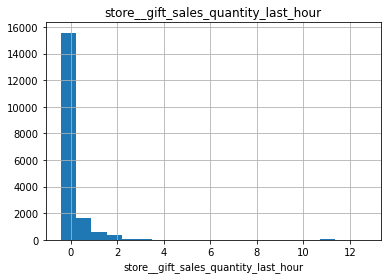

count   18512.000000
mean       -0.001778
std         1.006207
min        -0.434500
5%         -0.434400
10%        -0.434200
20%        -0.433400
30%        -0.431200
40%        -0.426800
50%        -0.413200
60%        -0.369340
70%        -0.213400
80%         0.082680
90%         1.028760
95%         2.136490
99%         3.944368
max        18.339500
Name: store__returns_dollar_amt_last_hour, dtype: float64


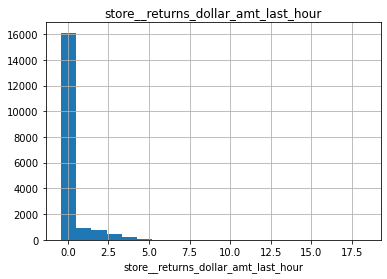

count   18512.000000
mean       -0.000283
std         1.011181
min        -0.547700
5%         -0.546200
10%        -0.545100
20%        -0.541200
30%        -0.517000
40%        -0.471800
50%        -0.397400
60%        -0.268340
70%        -0.098660
80%         0.225760
90%         1.079770
95%         1.800850
99%         4.828692
max        15.099000
Name: store__returns_quantity_last_hour, dtype: float64


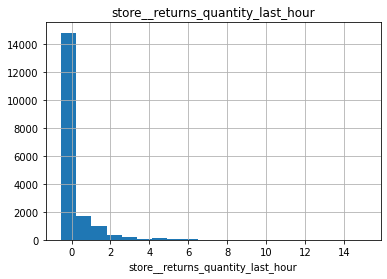

count   18512.000000
mean        0.006926
std         1.009954
min        -0.330100
5%         -0.330100
10%        -0.330100
20%        -0.330100
30%        -0.330100
40%        -0.330100
50%        -0.329300
60%        -0.324000
70%        -0.300930
80%        -0.209400
90%         0.451790
95%         2.565690
99%         4.774067
max         5.343800
Name: store__returns_quantity_rescanned_frac, dtype: float64


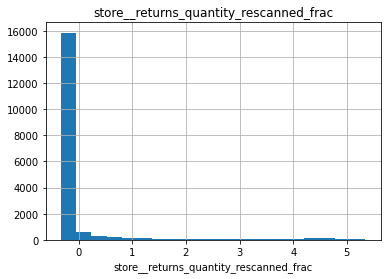

count   18512.000000
mean       -0.004067
std         0.971675
min        -0.294800
5%         -0.294800
10%        -0.294800
20%        -0.294800
30%        -0.284700
40%        -0.264500
50%        -0.219100
60%        -0.153600
70%        -0.062800
80%         0.088500
90%         0.325600
95%         0.835100
99%         3.185600
max        33.712100
Name: store__gift_returns_quantity_last_hour, dtype: float64


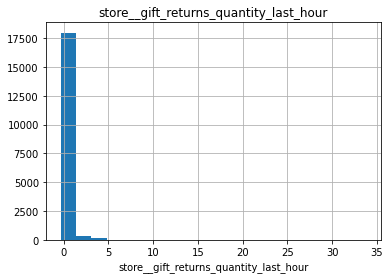

count   18512.000000
mean        0.014392
std         1.010495
min        -0.783400
5%         -0.783400
10%        -0.759900
20%        -0.759900
30%        -0.759900
40%        -0.736400
50%        -0.665800
60%        -0.383800
70%         1.496800
80%         1.496800
90%         1.496800
95%         1.496800
99%         1.496800
max         5.234400
Name: region__n_stores, dtype: float64


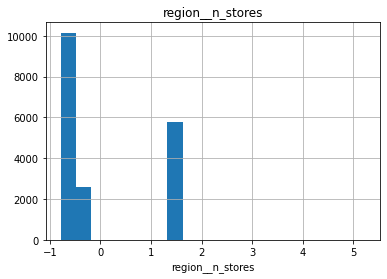

count   18512.000000
mean        0.017364
std         1.008064
min        -0.725700
5%         -0.722000
10%        -0.722000
20%        -0.718400
30%        -0.678200
40%        -0.641600
50%        -0.616000
60%        -0.597800
70%         1.047200
80%         1.379900
90%         1.613800
95%         1.814900
99%         2.058997
max         2.505800
Name: region__n_open_registers, dtype: float64


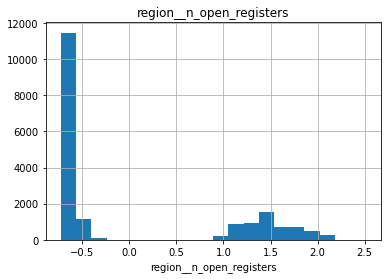

count   18512.000000
mean        0.020981
std         0.991513
min        -1.274300
5%         -1.258000
10%        -1.234100
20%        -0.789800
30%        -0.342500
40%        -0.280000
50%        -0.232600
60%        -0.128700
70%         0.455260
80%         0.886600
90%         1.126400
95%         1.751000
99%         3.204400
max        15.733500
Name: region__mean_service_time_per_customer, dtype: float64


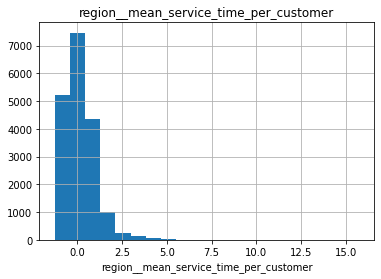

count   18512.000000
mean        0.006291
std         0.997525
min        -0.521400
5%         -0.491600
10%        -0.484000
20%        -0.480100
30%        -0.461000
40%        -0.451180
50%        -0.430300
60%        -0.323600
70%         0.017100
80%         0.214100
90%         0.557300
95%         2.175400
99%         4.599900
max         6.108400
Name: region__stdev_service_time_per_customer, dtype: float64


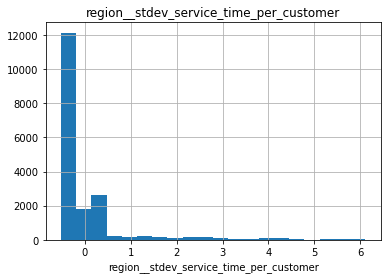

count   18512.000000
mean        0.017787
std         1.015479
min        -0.693400
5%         -0.679500
10%        -0.661000
20%        -0.651900
30%        -0.647500
40%        -0.560740
50%        -0.458600
60%        -0.399600
70%        -0.033700
80%         1.044900
90%         1.582100
95%         2.011000
99%         2.437100
max         9.338400
Name: region__sales_dollar_amt_last_hour, dtype: float64


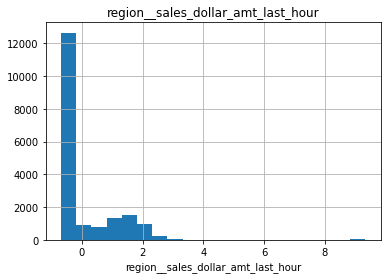

count   18512.000000
mean        0.006959
std         1.039629
min        -0.461800
5%         -0.456900
10%        -0.443900
20%        -0.442200
30%        -0.440500
40%        -0.327900
50%        -0.229500
60%        -0.035400
70%         0.227900
80%         0.379980
90%         0.628760
95%         0.844700
99%         1.313400
max        19.881600
Name: region__returns_dollar_amt_last_hour, dtype: float64


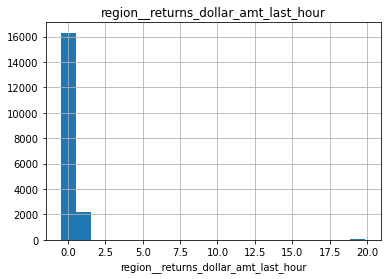

count   18512.000000
mean        0.014840
std         1.005610
min        -0.649800
5%         -0.649800
10%        -0.649800
20%        -0.649800
30%        -0.604000
40%        -0.592500
50%        -0.558100
60%        -0.518000
70%         0.347400
80%         0.656900
90%         2.089600
95%         2.135500
99%         2.169900
max         2.169900
Name: region__nighttime_open_registers, dtype: float64


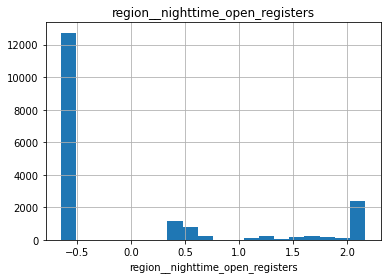

count   18512.000000
mean        0.021682
std         0.978837
min        -1.422900
5%         -1.409700
10%        -1.409400
20%        -1.006500
30%        -0.714800
40%         0.044800
50%         0.047700
60%         0.050200
70%         0.886700
80%         0.896600
90%         0.956000
95%         1.520500
99%         1.608800
max        11.537500
Name: region__nighttime_service_time_per_customer, dtype: float64


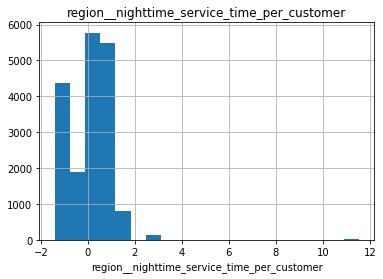

count   18512.000000
mean        0.018446
std         1.007041
min        -0.649300
5%         -0.649300
10%        -0.649300
20%        -0.649300
30%        -0.648700
40%        -0.647800
50%        -0.647100
60%        -0.646100
70%         0.914600
80%         1.574500
90%         1.683100
95%         1.769900
99%         1.827500
max         1.827500
Name: region__nighttime_sales_amt_per_hour, dtype: float64


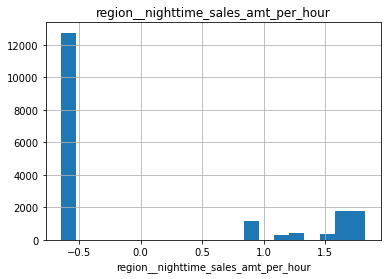

count   18512.000000
mean        0.015523
std         1.005561
min        -0.610600
5%         -0.610600
10%        -0.610600
20%        -0.610600
30%        -0.609100
40%        -0.608100
50%        -0.603700
60%        -0.603100
70%         0.328000
80%         0.903000
90%         1.989600
95%         2.051300
99%         2.068900
max         2.068900
Name: region__nighttime_returns_amt_per_hour, dtype: float64


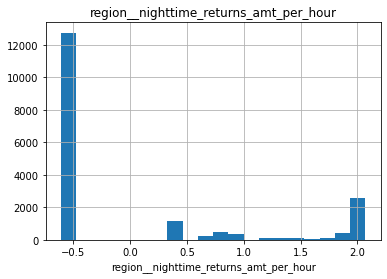

count   18512.000000
mean       -0.019027
std         0.996364
min        -2.259200
5%         -1.977900
10%        -1.977900
20%        -0.539400
30%        -0.173300
40%         0.033200
50%         0.033200
60%         0.128800
70%         0.440000
80%         0.499800
90%         1.002000
95%         1.933700
99%         2.431500
max         3.614100
Name: region__peak_sales_dollar_amt_per_hour, dtype: float64


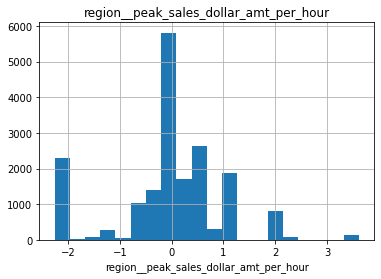

count   18512.000000
mean        0.008615
std         1.008285
min        -2.337000
5%         -1.795100
10%        -1.795100
20%        -0.363000
30%        -0.348900
40%        -0.348900
50%        -0.308000
60%        -0.131100
70%         0.516000
80%         0.893900
90%         1.115000
95%         1.729000
99%         2.404600
max         2.404600
Name: region__peak_returns_dollar_amt_per_hour, dtype: float64


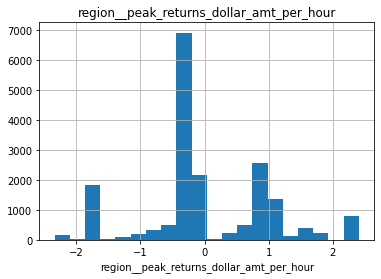

In [ ]:
for col in cat_cols:
    cat_summary(train, col, plot=True)
for col in num_cols:
    num_summary(train, col, plot=True)

**Target Value Analysis**

In [ ]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col:"mean"}), end="\n\n\n")
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}),
          end="\n\n\n")
for col in cat_cols:
    target_summary_with_cat(train,"register__sales_dollar_amt_this_hour",col)

                                  TARGET_MEAN
register__payment_types_accepted             
Cash+Credit                       1068.974663
Cash+Credit+Check                 1963.789180
Credit                             461.772319


                  TARGET_MEAN
store__type_code             
A                 1193.143505
B                 1453.316713
C                  955.118902
D                 3376.402816
E                  496.970000
F                  662.494000


                      TARGET_MEAN
cashier__title_level             
-2.603600              236.054698
-0.352000              963.708216
1.899600              2181.678173


                             TARGET_MEAN
cashier__n_years_experience             
-2.537100                     223.145305
-0.745400                    1577.588103
1.046300                      723.669191
2.838000                     1252.533537


                          TARGET_MEAN
store__n_employees_total             
-2.904100                 2222

**Correlations**

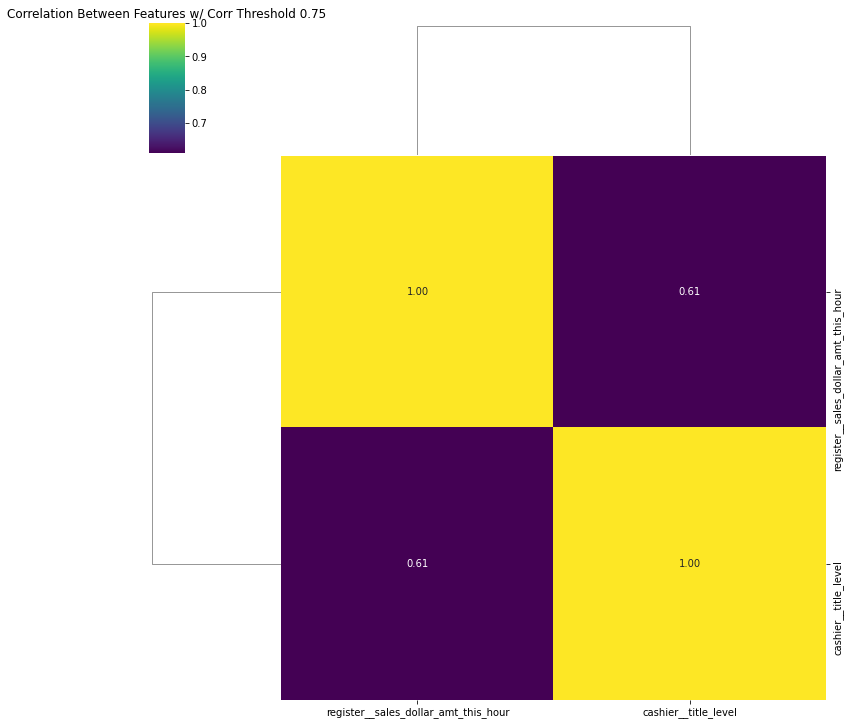

In [ ]:
corr_matrix = train.corr()
threshold = 0.5
filtre = np.abs(corr_matrix["register__sales_dollar_amt_this_hour"]) > threshold
corr_features=corr_matrix.columns[filtre].tolist()
sns.clustermap (train[corr_features].corr(), annot = True, fmt = ".2f",cmap = "viridis")
plt.title("Correlation Between Features w/ Corr Threshold 0.75")
plt.show()

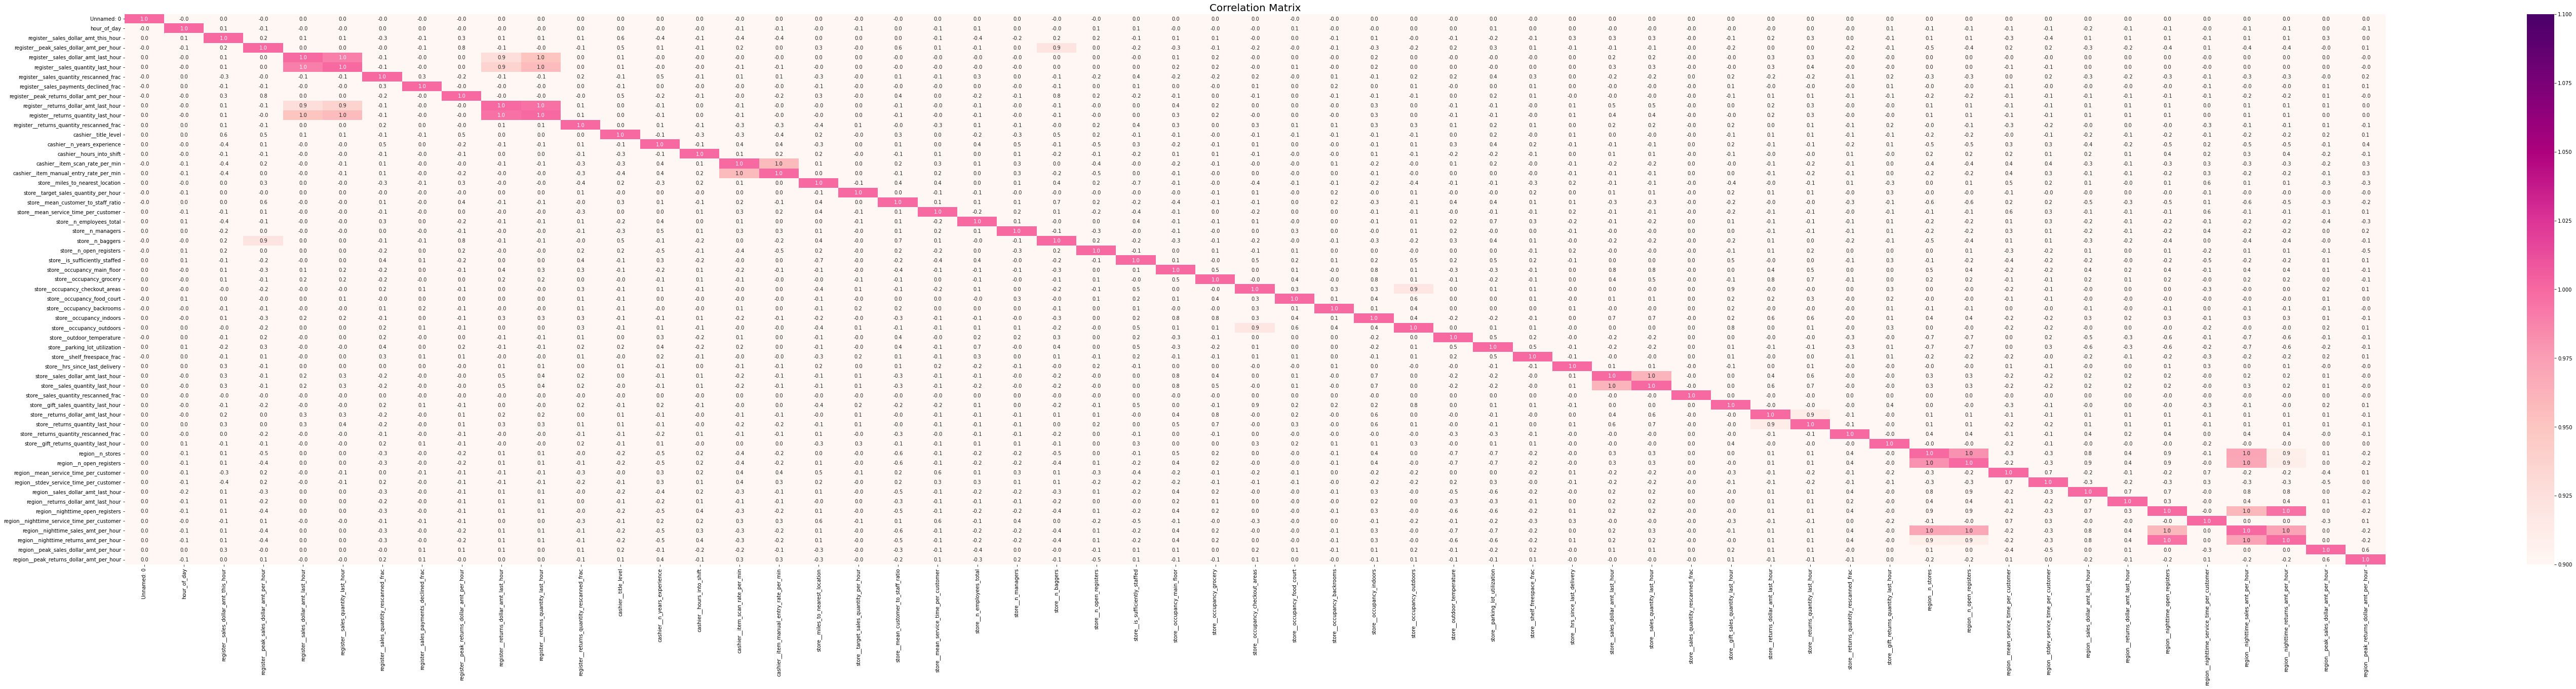

In [ ]:
f, ax = plt.subplots(figsize=[100, 20])
sns.heatmap(train.corr(), annot=True, fmt=".1f", ax=ax, cmap="RdPu",vmin=1)
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [ ]:
train.head()

,Unnamed: 0,observation_id,observation_timestamp,hour_of_day,register__sales_dollar_amt_this_hour,register__payment_types_accepted,register__peak_sales_dollar_amt_per_hour,register__sales_dollar_amt_last_hour,register__sales_quantity_last_hour,register__sales_quantity_rescanned_frac,register__sales_payments_declined_frac,register__peak_returns_dollar_amt_per_hour,register__returns_dollar_amt_last_hour,register__returns_quantity_last_hour,register__returns_quantity_rescanned_frac,cashier__title_level,cashier__n_years_experience,cashier__hours_into_shift,cashier__item_scan_rate_per_min,cashier__item_manual_entry_rate_per_min,store__type_code,store__miles_to_nearest_location,store__target_sales_quantity_per_hour,store__mean_customer_to_staff_ratio,store__mean_service_time_per_customer,store__n_employees_total,store__n_managers,store__n_baggers,store__n_open_registers,store__is_sufficiently_staffed,store__occupancy_main_floor,store__occupancy_grocery,store__occupancy_checkout_areas,store__occupancy_food_court,store__occupancy_backrooms,store__occupancy_indoors,store__occupancy_outdoors,store__outdoor_temperature,store__parking_lot_utilization,store__shelf_freespace_frac,store__hrs_since_last_delivery,store__sales_dollar_amt_last_hour,store__sales_quantity_last_hour,store__sales_quantity_rescanned_frac,store__gift_sales_quantity_last_hour,store__returns_dollar_amt_last_hour,store__returns_quantity_last_hour,store__returns_quantity_rescanned_frac,store__gift_returns_quantity_last_hour,region__n_stores,region__n_open_registers,region__mean_service_time_per_customer,region__stdev_service_time_per_customer,region__sales_dollar_amt_last_hour,region__returns_dollar_amt_last_hour,region__nighttime_open_registers,region__nighttime_service_time_per_customer,region__nighttime_sales_amt_per_hour,region__nighttime_returns_amt_per_hour,region__peak_sales_dollar_amt_per_hour,region__peak_returns_dollar_amt_per_hour
0,0,704d2a80-d52e-11ec-90ff-c7e6292284b3,2022-05-16 15:39:57,15,347.290000,Cash+Credit,-0.738300,-0.127000,-0.199300,-0.829900,-0.124700,-0.572100,-0.258200,-0.262100,-0.533700,-2.603600,-2.537100,1.055100,0.915600,0.677300,A,0.456400,-0.009200,0.843200,-0.644900,0.058000,-0.365700,0.165700,0.464000,-0.390900,-0.632500,-0.709900,-0.438600,-0.568800,0.072100,-0.883800,-0.561400,0.637600,0.178900,0.384000,-0.309300,-0.548700,-0.587100,-0.012400,-0.409500,-0.430800,-0.527400,-0.330100,-0.284700,-0.759900,-0.597800,-0.925500,-0.389100,-0.692000,-0.460500,-0.518000,-1.006200,-0.646200,-0.603000,-0.477300,-1.795100
1,1,1cacc1d0-e6ac-11ec-b65d-156af70ce36b,2022-06-07 21:52:23,21,361.590000,Cash+Credit,0.648300,-0.036200,-0.077700,-0.739500,-0.113500,-0.525100,-0.215700,-0.125200,-0.285300,-0.352000,1.046300,-0.262800,0.915600,0.573100,A,0.715500,-0.011400,1.196400,0.664900,-0.296000,1.924300,0.165700,-0.579600,-0.390900,-0.419800,0.345700,-0.438600,0.461800,-0.101900,-0.120500,-0.169500,0.637600,-1.108500,-1.429300,-1.105900,-0.460800,-0.379600,-0.012400,-0.411900,-0.163200,-0.262300,-0.330100,-0.279700,-0.759900,-0.714700,0.781500,0.066300,-0.653100,-0.443400,-0.649800,0.903100,-0.649300,-0.610600,0.499800,0.893900
2,2,6dc2b330-d37a-11ec-884e-dfe9ea4a7bd5,2022-05-14 11:38:52,11,850.730000,Cash+Credit,-0.495000,-0.126800,-0.197400,1.313900,0.107500,-0.525100,-0.257900,-0.254200,-0.112500,-0.352000,1.046300,-0.688400,-0.011800,0.052000,A,-2.134200,0.070800,-0.216600,-1.122900,0.954900,-0.365700,-0.637100,-0.753600,2.558200,-0.641300,-0.751200,3.485400,-0.270600,0.412500,0.088800,2.655600,-0.205200,1.199900,0.643100,-0.836700,-0.548800,-0.592100,-0.012400,3.500400,-0.433500,-0.539100,-0.330100,0.189400,-0.336700,-0.678200,-1.255900,-0.482600,-0.612000,-0.178600,-0.604000,-1.422900,-0.645600,-0.603700,1.933700,2.404600
3,3,163ee0a0-0cca-11ed-a73c-8904b24187cc,2022-07-26 10:02:41,10,1175.690000,Cash+Credit,-0.559400,-0.127000,-0.199100,-0.829900,-0.124700,-0.525100,-0.258200,-0.261600,-0.295800,-0.352000,1.046300,-0.202400,-0.217800,-0.052200,A,

# **Feature Engineering**

In [ ]:
def drop_features(df,unnamed=False):
    df.drop('observation_id',axis=1,inplace=True)
    df.drop('hour_of_day',axis=1,inplace=True)
    if unnamed:
        df.drop('Unnamed: 0',axis=1,inplace=True)

def timestamp_changer(df,date_time):
    df[date_time] = pd.to_datetime(df[date_time]).dt.strftime('%d.%m.%Y.%H:%M')
    df[date_time] = pd.to_datetime(df[date_time])
    years = df[date_time].dt.year
    months = df[date_time].dt.month
    day_of_months = df[date_time].dt.day
    hours = df[date_time].dt.hour
    days = df[date_time].dt.day_name()
    def daypart(hour):
        if hour in [2,3,4,5]:
            return "dawn"
        elif hour in [6,7,8,9]:
            return "morning"
        elif hour in [10,11,12,13]:
            return "noon"
        elif hour in [14,15,16,17]:
            return "afternoon"
        elif hour in [18,19,20,21]:
            return "evening"
        else: return "midnight"
    dayparts = hours.apply(daypart)
    day_names = df[date_time].dt.day_name()
    is_weekend = day_names.apply(lambda x : 1 if x in ['Saturday','Sunday'] else 0)
    features = pd.DataFrame({
    'year' : years,
    'month' : months,
    'day_of_month' : day_of_months,
    'is_weekend' : is_weekend,
    'hour' : hours,
    'daypart' : dayparts
    })
    features = pd.concat([features, days, dayparts], axis = 1)
    return features
def change_timestamp(df,date_time):
    df_timestamp = timestamp_changer(df,date_time=date_time)
    for i in df_timestamp.columns:
        for j in range(len(df_timestamp.columns)):
            try:
                df.insert(j,column=i,value=df_timestamp[i])
                continue
            except:
                continue
    df.drop('observation_timestamp',axis=1,inplace=True)

In [ ]:
drop_features(train,unnamed=True)
drop_features(test)

change_timestamp(train,date_time='observation_timestamp')
change_timestamp(test,date_time='observation_timestamp')

In [ ]:
def insert_n_drop(df):
    df.insert(11,"register__real_sales_last_hour",value=(df['register__sales_quantity_last_hour'] - df['register__returns_quantity_last_hour']))
    df.insert(12,"refund_amount_per_unit",value=(df['store__returns_dollar_amt_last_hour'] / df['store__returns_quantity_last_hour']))
    df.insert(13,"return_rate_on_store_basis",value=(df['region__returns_dollar_amt_last_hour'] / df['region__n_stores'])*100)
    #df.drop(['region__nighttime_open_registers','region__nighttime_sales_amt_per_hour','region__nighttime_returns_amt_per_hour','store__sales_quantity_last_hour','register__sales_quantity_last_hour','register__returns_quantity_last_hour','store__returns_dollar_amt_last_hour','store__returns_quantity_last_hour','region__returns_dollar_amt_last_hour','region__n_stores'],axis=1,inplace=True)
insert_n_drop(train)
insert_n_drop(test)

**LabelEncoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder
def encode_features(df,columns):
    le = LabelEncoder()
    for i in columns:
        label = le.fit_transform(df[i])
        indexes = [list(label).index(x) for x in sorted(set(list(label)))]
        df[i] = label
        print(i,":",le.inverse_transform(label)[indexes],label[indexes])
    print("-"*40)
encode_feature = ['register__payment_types_accepted', 'daypart', 'store__type_code', 'store__n_employees_total', 'store__n_baggers', 'store__is_sufficiently_staffed']
encode_features(train,encode_feature)
encode_features(test,encode_feature)

register__payment_types_accepted : ['Cash+Credit' 'Cash+Credit+Check' 'Credit'] [0 1 2]
daypart : ['afternoon' 'dawn' 'evening' 'midnight' 'morning' 'noon'] [0 1 2 3 4 5]
store__type_code : ['A' 'B' 'C' 'D' 'E' 'F'] [0 1 2 3 4 5]
store__n_employees_total : [-2.9041 -1.4997 -1.3581 -0.5084 -0.296   0.058   0.9549  1.3797] [0 1 2 3 4 5 6 7]
store__n_baggers : [-0.6371  0.1657  1.7712  4.9823] [0 1 2 3]
store__is_sufficiently_staffed : [-0.3909  2.5582] [0 1]
----------------------------------------
register__payment_types_accepted : ['Cash+Credit' 'Cash+Credit+Check' 'Credit'] [0 1 2]
daypart : ['afternoon' 'dawn' 'evening' 'midnight' 'morning' 'noon'] [0 1 2 3 4 5]
store__type_code : ['A' 'B' 'C' 'D' 'E' 'F'] [0 1 2 3 4 5]
store__n_employees_total : [-2.9041 -1.4997 -1.3581 -0.5084 -0.296   0.058   0.9549  1.3797] [0 1 2 3 4 5 6 7]
store__n_baggers : [-0.6371  0.1657  1.7712  4.9823] [0 1 2 3]
store__is_sufficiently_staffed : [-0.3909  2.5582] [0 1]
-------------------------------------

# **Outlier Analysis&Handling**

In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75): # low and up limit hesaplamaya yarayan fonksiyon.
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def check_outlier(dataframe, col_name): # Girilen veri setinin girilen kolonunda outlier var mı bulmaya yarayan fonksiyon.
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
def grab_outliers(dataframe, col_name, index=False): # Outlier'ları indeksleriyle birlikte verir 
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10: #shape[0]: gözlem sayısı, shape[1] : değişken sayısı
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
def num_replace(df):
    for col in df.select_dtypes(include=['float64','int64']):
        replace_with_thresholds(df, col)
def check_num_outlier(df):
    for col in df.select_dtypes(include=['float64','int64']):
        print(col, check_outlier(df, col))

In [ ]:
for col in train.drop('register__sales_dollar_amt_this_hour',axis=1).columns:
    replace_with_thresholds(train,col)
    replace_with_thresholds(test,col)

# **Missing Value Analysis**

In [ ]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns
missing_values_table(train)
missing_values_table(test)

NameError: ignored

In [ ]:
msno.bar(train);

In [ ]:
msno.matrix(train);

# **Modeling Scaling Processes**

In [ ]:

#STANDARDSCALER
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(train.drop('register__sales_dollar_amt_this_hour',axis=1)),columns=train.drop('register__sales_dollar_amt_this_hour',axis=1).columns)
y_train = train['register__sales_dollar_amt_this_hour']

X_test = pd.DataFrame(scaler.transform(test),columns=test.columns)
# y_test does not exist
#'region__peak_sales_dollar_amt_per_hour_v2','region__peak_returns_dollar_amt_per_hour_v2'


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
"""from sklearn.preprocessing import RobustScaler
scaler = preprocessing.RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(train.drop('register__sales_dollar_amt_this_hour',axis=1)),columns=train.drop('register__sales_dollar_amt_this_hour',axis=1).columns)
y_train = train['register__sales_dollar_amt_this_hour']

X_test = pd.DataFrame(scaler.transform(test),columns=test.columns)
# y_test does not exist
#'region__peak_sales_dollar_amt_per_hour_v2','region__peak_returns_dollar_amt_per_hour_v2'"""

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
def PrepModel(Dataframe,Dependent):
    X = Dataframe.drop(Dependent, axis=1)
    y = Dataframe[Dependent] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)
    X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)
    models = [('LR', LinearRegression()),
          ('Lasso', Lasso()),
          ('Ridge', Ridge()),
          ('ElasticNet', ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('RF', RandomForestRegressor(bootstrap=True, max_depth=4682, max_features=15, max_leaf_nodes=948, min_samples_leaf=3, n_estimators=223)),
          ('GBM', GradientBoostingRegressor()),
          ("XGB", XGBRegressor()),
          ("LGBM", LGBMRegressor())
          # ("CatBoost", CatBoostRegressor(verbose=False))
          ]
    for name, regressor in models:
        modell = regressor.fit(X_train, y_train)
        y_pred = modell.predict(X_test)
        print(name + " RMSE Değeri: ", np.sqrt(mean_squared_error(y_test, y_pred)))
        rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
        print(name, f"RMSE crossval Değeri: {round(rmse, 4)} ({name}) ")

In [ ]:
"""
standard scaling - features not dropped  : 166
standard scaling - features dropped : 165.8

robust scaling - features not dropped : 164.9
robust scaling - features dropped : 165.5
"""
PrepModel(train,'register__sales_dollar_amt_this_hour')

In [ ]:
#### ROBUST USED FOR SELECTING HYPERPARAMETERS  
from sklearn import ensemble
from sklearn import model_selection
def objective(trial):
    bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
    max_depth = trial.suggest_int('max_depth', 1, 10000)
    max_features = trial.suggest_categorical('max_features', [5, 7, 10, 15,'auto', 'sqrt','log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',1, 1000)
    n_estimators =  trial.suggest_int('n_estimators', 10, 1000)
    
    regr = RandomForestRegressor(bootstrap = bootstrap,
                                 max_depth = max_depth, max_features = max_features,
                                 max_leaf_nodes = max_leaf_nodes,min_samples_leaf = min_samples_leaf,n_estimators = n_estimators,n_jobs=2)
    
    
    #regr.fit(X_train, y_train)
    #y_pred = regr.predict(X_val)
    #return r2_score(y_val, y_pred)
    
    score = cross_val_score(regr, X_train, y_train, cv=5, scoring="r2")
    r2_mean = score.mean()

    return r2_mean
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

#Create an instance with tuned hyperparameters
optimised_rf = RandomForestRegressor(bootstrap = study.best_params['bootstrap'], criterion = study.best_params['criterion'],
                                     max_depth = study.best_params['max_depth'], max_features = study.best_params['max_features'],
                                     max_leaf_nodes = study.best_params['max_leaf_nodes'],n_estimators = study.best_params['n_estimators'],
                                     n_jobs=2)

In [ ]:
model = RandomForestRegressor(bootstrap=True, max_depth=4682, max_features=15, max_leaf_nodes=948, min_samples_leaf=3, n_estimators=223)
model.fit(X_train,y_train) 

RandomForestRegressor(max_depth=4682, max_features=15, max_leaf_nodes=948,
                      min_samples_leaf=3, n_estimators=223)

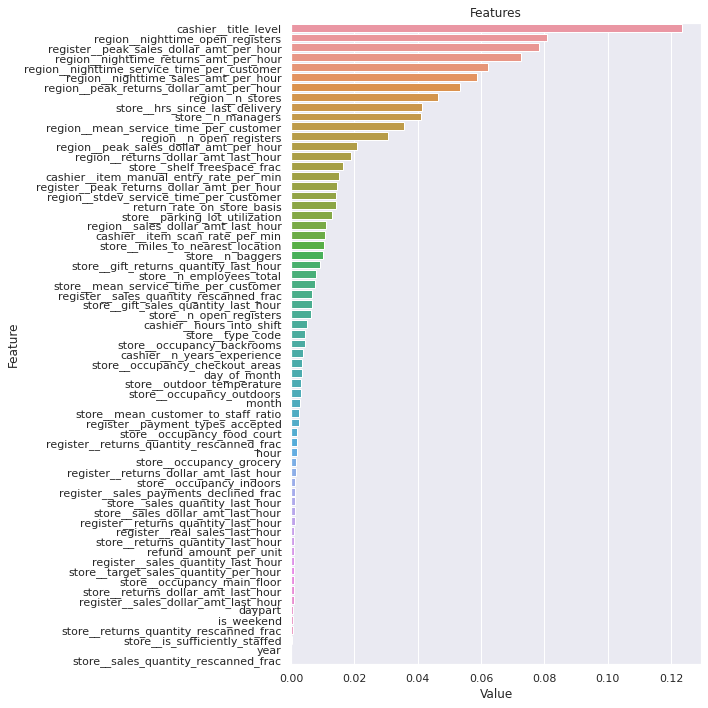

In [ ]:

def plot_importance(model, features, num=len(X_train), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    global feature
    feature = feature_imp['Feature'][:20]
    plt.show()
plot_importance(model,X_train)

In [ ]:
predictions = model.predict(X_test)
results_df = pd.DataFrame({'prediction':predictions})
results_df.to_csv('/content/predictions.csv',index=False)
results_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


,prediction
0,1867.664458
1,388.276683
2,1338.543227
3,308.104009
4,353.241287


Public Score: erencicee - 87.27 - 6.place Link: https://dphi.tech/challenges/juniper-networks-global-ai-challenge/286/leaderboard/public/

Private Score: azilizeynep - 72.58 - 5.place Link: https://dphi.tech/challenges/juniper-networks-global-ai-challenge/286/leaderboard/private/

Although this competition is our first, we believe that we got on hand very good scoring.